
# EDA: MICUSP Upper‑Level Student Essays — Structural & Signal Properties

This notebook performs an **exploratory data analysis (EDA)** on the **MICUSP** upper‑level student essays
(`data/micusp/MICUSP_byDept-ASCII`), adapting the same ideas we used
for the Reuters_50_50 corpus. A main goal is to establish a **human baseline** for student academic writing, so
we can later contrast against model‑generated text.  Another significant goal is to figure out how we will need 
to clean the dataset for use in downstream processing.

**Expected layout (examples):**
```
data/micusp/MICUSP_byDept-ASCII/
├── BIO/
│   ├── BIO.G0.01.1_F_NS.txt
│   ├── BIO.G1.05.3_M_NN.txt
├── ENG/
│   ├── ENG.G0.06.2_F_NS.txt
│   └── ...
├── HIS_CLS/
│   ├── HIS_CLS.G2.02.1_F_NS.txt
│   └── ...
└── ... (other departments)
```

## What’s different vs newswire (Reuters)?
Student essays differ from newswire in several ways that we account for:
- One essay (BIO.G0.01.1_F_NS.txt) appears to have **Title, Outline, and Bibliography**.
- **Longer, more varied paragraphs**; more **citations** (e.g., `Smith (2012)`, `(Jones & Lee, 2019)`).
- Different punctuation & discourse markers (e.g., **“however”**, **“therefore”**, **“albeit”**).
- Possibly more use of **passive voice**.
- Domain‑specific vocabulary shifts across departments (BIO vs ENG vs HIS_CLS, etc.).

We’ll re‑run most of the same calculations but **tweak**:
- Stopword list (remove Reuters‑specific boilerplate; add light academic extras).
- Corpus fields (`department` instead of `author`; filenames parsed from MICUSP).
- Add **essay‑specific features**: citation density, paragraph structure, a light passive‑voice heuristic,
  and section‑cue frequencies (e.g., "introduction", "method", "results", "discussion", "conclusion").


In [1]:

# Imports
import re
import string
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt  # Do not set styles or colors
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

# -------- CONFIG --------
BASE_DIR = Path("data/micusp/MICUSP_byDept-ASCII")
SAVE_DIR = Path("eda_outputs/micusp_student_essays")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Tokenization & sentence splitting (lightweight)
WORD_RE: re.Pattern = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")
SENT_SPLIT_RE: re.Pattern = re.compile(r"[.!?]+(?:\s+|$)")

PARA_SEP_RE = re.compile(
    r"(?: {4,}|\t{2,}| {2,}\t+|\t+ {2,})"
)

# Heading flags (for later preprocessing/pipeline decisions)
TOC_RE = re.compile(r"\btable of contents\b", re.IGNORECASE)
BIB_RE = re.compile(r"\b(bibliography|references|works\s+cited)\b", re.IGNORECASE)

def simple_sent_tokenize(text: str) -> list[str]:
    parts = SENT_SPLIT_RE.split(text)
    return [p.strip() for p in parts if p.strip()]

def simple_word_tokenize(text: str) -> list[str]:
    return WORD_RE.findall(text.lower())

def simple_para_split(text: str) -> list[str]:
    """
    Split MICUSP essays into paragraphs using ASCII spacing/tabs as separators.
    Falls back to a single paragraph if no separators are found.
    """
    # 1) Primary split on spacing/tab separators
    parts = PARA_SEP_RE.split(text)
    paras = [p.strip() for p in parts if p and p.strip()]

    # 2) If still one giant block, avoid over-splitting: just return as single paragraph
    #    (we'll handle richer rules in a later preprocessing pipeline)
    if len(paras) <= 1:
        return [text.strip()] if text.strip() else []

    return paras

def micusp_doc_flags(text: str) -> dict:
    """Lightweight flags; do NOT modify text/metrics yet."""
    has_toc = bool(TOC_RE.search(text))
    has_bib = bool(BIB_RE.search(text))
    return {"has_toc": has_toc, "has_bib": has_bib}

print("Environment ready.")


Environment ready.


In [2]:

def read_micusp_docs(base_dir: Path) -> pd.DataFrame:
    """
    Assumes files like:
      data/micusp/MICUSP_byDept-ASCII/SUBJECT/SUBJECT.G0.01.1_F_NS.txt
    We'll treat SUBJECT (directory name) as `department`, and store filename parts.
    """
    rows = []
    if not base_dir.exists():
        raise FileNotFoundError(f"Base dir not found: {base_dir}")
    for dept_dir in sorted([p for p in base_dir.iterdir() if p.is_dir()]):
        department = dept_dir.name
        for f in sorted(dept_dir.glob("*.txt")):
            try:
                txt = f.read_text(encoding="utf-8")
            except UnicodeDecodeError:
                txt = f.read_text(encoding="latin-1", errors="ignore")
            fname = f.name
            rows.append({
                "department": department,
                "filename": fname,
                "path": str(f),
                "text": txt
            })
    return pd.DataFrame(rows)

df = read_micusp_docs(BASE_DIR)
print(f"Total docs: {len(df)}")
print("Departments:", df['department'].nunique(), sorted(df['department'].unique())[:10], "...")

def doc_stats(text: str) -> dict[str, int | float | bool]:
    sents = simple_sent_tokenize(text)
    words = simple_word_tokenize(text)
    paras = simple_para_split(text)
    has_toc = bool(TOC_RE.search(text))
    has_bib = bool(BIB_RE.search(text))
    return {
        "n_chars": len(text),
        "n_sents": len(sents),
        "n_words": len(words),
        "n_paras": len(paras),
        "avg_words_per_para": (len(words) / max(1, len(paras))),
        "has_toc": has_toc,
        "has_bib": has_bib,
    }


basic = df["text"].apply(doc_stats).apply(pd.Series)
df = pd.concat([df, basic], axis=1)
corpus_summary = {
    "n_docs": int(len(df)),
    "n_departments": int(df["department"].nunique()),
    "words_total": int(df["n_words"].sum()),
    "words_mean": float(df["n_words"].mean()),
    "words_median": float(df["n_words"].median()),
    "sents_mean": float(df["n_sents"].mean()),
    "sents_median": float(df["n_sents"].median()),
    "paras_mean": float(df["n_paras"].mean()),
    "avg_words_per_para_mean": float(df["avg_words_per_para"].mean()),
    "has_toc": sum(df["has_toc"]),
    "has_bib": sum(df["has_bib"]),
}

display(pd.DataFrame([corpus_summary]))


Total docs: 829
Departments: 16 ['BIO', 'CEE', 'ECO', 'EDU', 'ENG', 'HIS_CLS', 'IOE', 'LIN', 'MEC', 'NRE'] ...


,n_docs,n_departments,words_total,words_mean,words_median,sents_mean,sents_median,paras_mean,avg_words_per_para_mean,has_toc,has_bib
0,829,16,2570534,3100.764777,2486.0,157.262967,122.0,39.316043,105.526688,17,468


## Document Length
We can see that there is a fairly significant difference in the size and structure of the documents as compared with the Reuters dataset, which had the following statistics:

```
n_docs      n_authors   words_total words_mean  words_median    sents_mean  sents_median
5000        50          2495704     499.1408    504.0           22.4984     22.0
```
## Paragraphs
Ignore these -- I don't have the right paragraph splitting

## Table of Contents and Bibliographies
I'm going to have to figure out a way to clean these.  Additionally, there are titles and other artifacts that we may want to clean out.

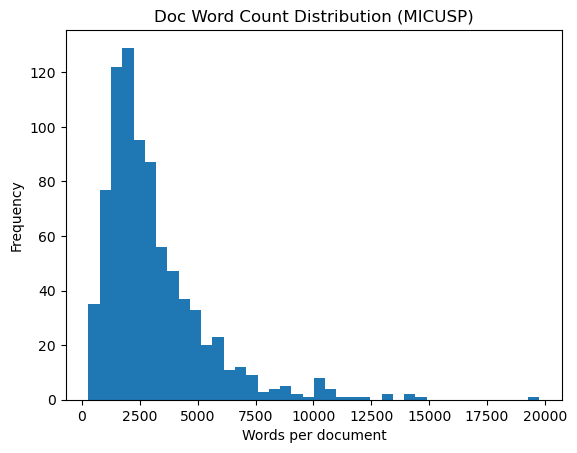

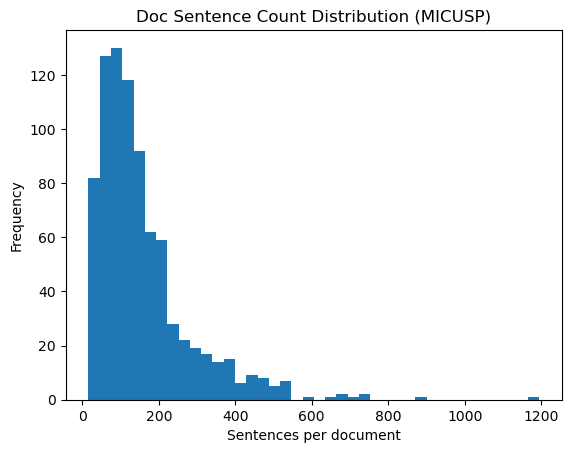

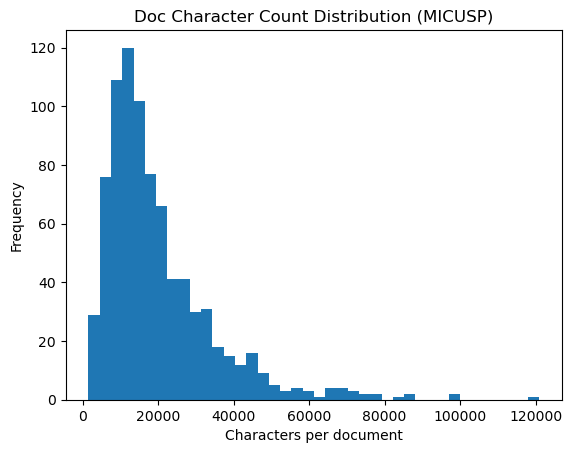

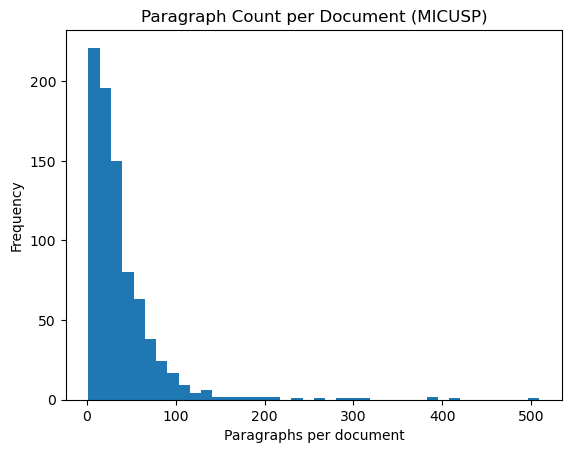

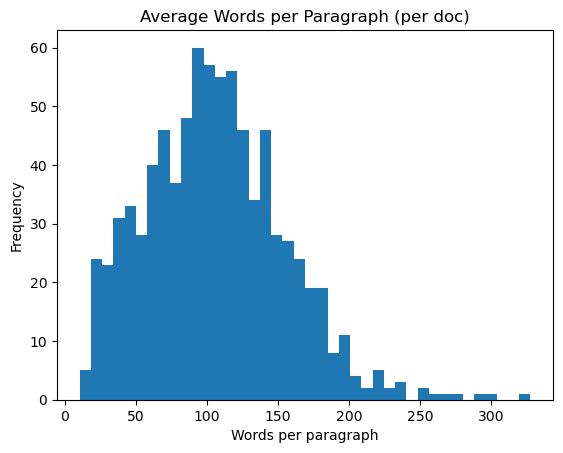

In [3]:
"""Section 1

Corpus overview
"""

# Histograms
plt.figure()
plt.hist(df["n_words"], bins=40)
plt.title("Doc Word Count Distribution (MICUSP)")
plt.xlabel("Words per document"); plt.ylabel("Frequency")
plt.savefig(SAVE_DIR / "section1_word_count_distribution.png")
plt.show()

plt.figure()
plt.hist(df["n_sents"], bins=40)
plt.title("Doc Sentence Count Distribution (MICUSP)")
plt.xlabel("Sentences per document"); plt.ylabel("Frequency")
plt.savefig(SAVE_DIR / "section1_sent_count_distribution.png")
plt.show()

plt.figure()
plt.hist(df["n_chars"], bins=40)
plt.title("Doc Character Count Distribution (MICUSP)")
plt.xlabel("Characters per document"); plt.ylabel("Frequency")
plt.savefig(SAVE_DIR / "section1_char_count_distribution.png")
plt.show()

plt.figure()
plt.hist(df["n_paras"], bins=40)
plt.title("Paragraph Count per Document (MICUSP)")
plt.xlabel("Paragraphs per document"); plt.ylabel("Frequency")
plt.savefig(SAVE_DIR / "section1_para_count_distribution.png")
plt.show()

plt.figure()
plt.hist(df["avg_words_per_para"], bins=40)
plt.title("Average Words per Paragraph (per doc)")
plt.xlabel("Words per paragraph"); plt.ylabel("Frequency")
plt.savefig(SAVE_DIR / "section1_avg_words_per_para_distribution.png")
plt.show()


## Section 1: Corpus Overview — MICUSP Student Essays

- **Corpus size:** 829 documents from 16 departments (e.g., BIO, ENG, HIS_CLS, MEC).  
- **Total words:** ~2.57M; **mean words/doc:** ~3,101 (median 2,486).  
- **Sentences:** mean ~157 per doc (median 122).  
- **Characters:** cluster around 10k–20k, with outliers >100k.  

### Document Lengths
- Word and sentence counts show **strong right-skew**.  
- Most essays: **1,000–5,000 words** (50–250 sentences).  
- Long tail includes very long submissions (>20k words, >1,000 sentences).  
- Compared to Reuters, essays are **longer, more variable, and less standardized**.

### Paragraph Structure
- Ignore for now.

### Implications
- Essays provide a more **heterogeneous human baseline** vs. the uniformity of newswire.  
- This variability reflects authentic academic writing but complicates direct comparison with LLM outputs.  
- Paragraph segmentation should be improved before analyzing cohesion or burstiness at the paragraph level.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dma0523/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


BASE stopwords: 198 | academic extras: 12 | total: 210


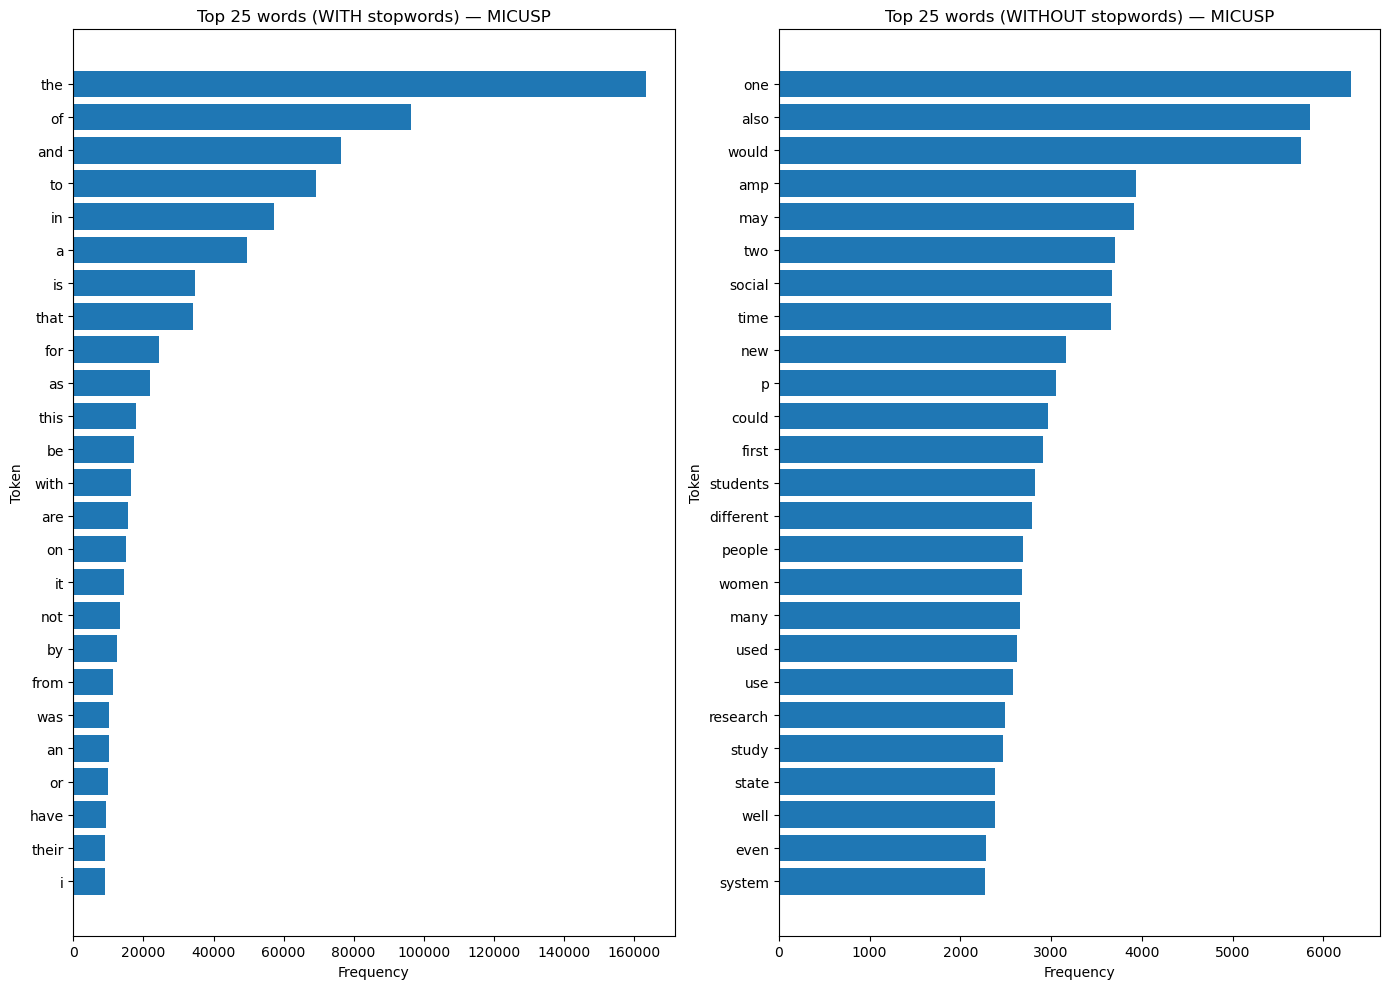

,Word1,Word2,Word3,Word4,Word5
Letter,,,,,
A,a'anapu,aaaaah,aaber,aac,aacn
B,baalim,baarle,baartman,baba,babe
C,c'est,caa,caballera,cabals,cabbage
D,d'addario,d'ambrosio,d'arcy,d'estaing,d'ivoire
E,eaa,eab,eaching,eachthe,eacl
F,faade's,fabiani,fabliaux,fabricators,fabrics
G,gab,gabacciasitalys,gabble,gabby's,gabe
H,h'okmalni,haapamakia,haarman,habebit,habermasian
I,i'th,iadernykh,iaf,iambana,iatrogenic


Saved hapax table: eda_outputs/micusp_student_essays/section2_hapax_alphabet_table.csv


In [4]:
"""Section 2

Lexical Richness
"""
# Stopwords
nltk.download('stopwords')
BASE_SW = set(stopwords.words('english'))

ACADEMIC_EXTRAS = {
    "et", "al", "ibid", "cf", "eg", "ie",
    "however", "therefore", "hence", "thus", "furthermore", "moreover",
}
STOPWORDS = BASE_SW | ACADEMIC_EXTRAS
print(f"BASE stopwords: {len(BASE_SW)} | academic extras: {len(ACADEMIC_EXTRAS)} | total: {len(STOPWORDS)}")

all_tokens = []
for text in df["text"]:
    all_tokens.extend(simple_word_tokenize(text))

vocab_all = Counter(all_tokens)
vocab_no_sw = Counter([w for w in all_tokens if w not in STOPWORDS])

df_all = pd.DataFrame(list(vocab_all.items()), columns=["token", "count"]).sort_values("count", ascending=False, ignore_index=True)
df_no_sw = pd.DataFrame(list(vocab_no_sw.items()), columns=["token", "count"]).sort_values("count", ascending=False, ignore_index=True)

topN = 25
top_all_25   = df_all.head(topN).copy()
top_no_sw_25 = df_no_sw.head(topN).copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 10))
axes[0].barh(top_all_25["token"].iloc[::-1], top_all_25["count"].iloc[::-1])
axes[0].set_title(f"Top {topN} words (WITH stopwords) — MICUSP")
axes[0].set_xlabel("Frequency"); axes[0].set_ylabel("Token")

axes[1].barh(top_no_sw_25["token"].iloc[::-1], top_no_sw_25["count"].iloc[::-1])
axes[1].set_title(f"Top {topN} words (WITHOUT stopwords) — MICUSP")
axes[1].set_xlabel("Frequency"); axes[1].set_ylabel("Token")

plt.tight_layout()
plt.savefig(SAVE_DIR / "section2_top25_barcharts.png", dpi=200)
plt.show()

# Hapax legomena table
vocab = Counter(all_tokens)
hapax = [w for w, c in vocab.items() if c == 1 and w and w[0].isalpha()]

hapax_by_letter = {ch: [] for ch in string.ascii_lowercase}
for w in hapax:
    hapax_by_letter[w[0].lower()].append(w)

rows = {}
for ch in string.ascii_lowercase:
    words = sorted(hapax_by_letter.get(ch, []))[:5]
    words += [""] * (5 - len(words))
    rows[ch.upper()] = words

hapax_table = pd.DataFrame.from_dict(rows, orient="index", columns=["Word1","Word2","Word3","Word4","Word5"])
hapax_table.index.name = "Letter"
display(hapax_table)

hapax_csv_path = SAVE_DIR / "section2_hapax_alphabet_table.csv"
hapax_table.to_csv(hapax_csv_path)
print(f"Saved hapax table: {hapax_csv_path.as_posix()}")


## Section 2: Lexical Richness & Top Tokens

**Top-25 (WITH stopwords).** As expected, counts are dominated by function words (e.g., *the, of, and, to, in*). Notably, **“i”** appears, reflecting first-person usage common in student essays.

**Top-25 (WITHOUT stopwords).** Content words and discourse markers characteristic of academic prose rise to the top:
- **Hedging / discourse:** *also, would, may, could, first*  
- **Methods / results verbs:** *use, used, study, research*  
- **People / social terms:** *students, people, women*  
- **General academic nouns/adjectives:** *social, system, state, time, new, different, many, two, one*

These patterns differ clearly from newswire vocabulary and are consistent with student academic writing (enumeration, hedging, methodological reporting).

**Data artifacts to address.** Tokens like **“amp”** (HTML `&amp;`) and single-letter **“p”** suggest markup/encoding residue. These should be cleaned in a preprocessing pass (HTML entity decoding; drop isolated single letters except valid pronouns).

**Hapax legomena.** The hapax table (saved separately) will include many proper names, citation fragments, and typos—useful to inspect but typically excluded from stylometric features.

**Implications for downstream analysis.**
- Keep **hedging/discourse markers** (e.g., *may, could, also, first*) when modeling style; they’re informative for distinguishing human academic prose from LLM outputs.
- For topical vocabulary comparisons, consider removing or down-weighting those markers to focus on domain content.
- Plan a lightweight cleaner before final comparisons: HTML entity decoding, removal of stray single letters, optional normalization of quotes/dashes, and (if needed) department-stratified analyses to reduce topical confounds.


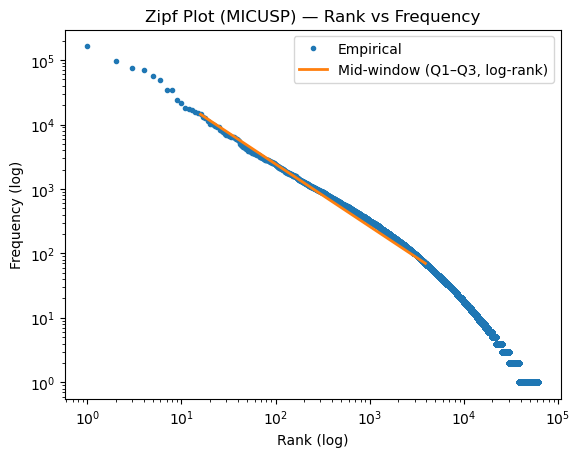

Saved: eda_outputs/micusp_student_essays/section2_zipf_plot.png


In [5]:

"""Zipf plot

For each unique token in the corpus, we compute its frequency and sort tokens by frequency rank. 
Rank is just the position in the sorted list (e.g. the most frequent word has a rank of 1, second-most has a rank of 2, etc). 
On log–log axes, natural language typically follows a power law. A straight line on the plot indicates this power-law behavior. 
"Alpha" is the estimated exponent.
"""
vocab = Counter(all_tokens)
freqs = np.array(sorted(vocab.values(), reverse=True), dtype=float)
ranks = np.arange(1, len(freqs) + 1, dtype=float)

N = len(freqs)
if N > 3:
    r1 = N ** 0.25
    r3 = N ** 0.75
    i1 = int(round(r1 - 1))
    i3 = int(round(r3 - 1))
    x1, y1 = ranks[i1], freqs[i1]
    x3, y3 = ranks[i3], freqs[i3]
else:
    x1=y1=x3=y3=1

plt.figure()
plt.loglog(ranks, freqs, marker='.', linestyle='none', label="Empirical")
if N > 3:
    plt.loglog([x1, x3], [y1, y3], linewidth=2, label="Mid-window (Q1–Q3, log-rank)")
plt.title("Zipf Plot (MICUSP) — Rank vs Frequency")
plt.xlabel("Rank (log)"); plt.ylabel("Frequency (log)")
plt.legend()
zipf_path = SAVE_DIR / "section2_zipf_plot.png"
plt.savefig(zipf_path, dpi=200)
plt.show()
print(f"Saved: {zipf_path.as_posix()}")


,department,path,n_words,n_sents,n_paras,avg_words_per_para,stopword_ratio,sent_len_mean,sent_len_std,punct_.,...,punct_-,punct_',punct_:,punct_(,punct_),"punct_""",punct_?,punct_[,punct_],punct_!
0,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.01....,5758,354,56,102.821429,0.429489,16.265537,12.010240,68.947551,...,7.815214,1.910386,2.257728,15.456756,15.804099,0.347343,0.173671,NaN,NaN,NaN
1,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,3794,265,36,105.388889,0.391144,14.316981,13.077039,85.134423,...,21.349499,6.589352,16.341592,29.256721,29.256721,8.961518,0.263574,1.054296,1.054296,NaN
2,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,818,37,8,102.250000,0.376528,22.108108,9.460540,44.009780,...,29.339853,17.114914,6.112469,12.224939,12.224939,4.889976,1.222494,3.667482,3.667482,NaN
3,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,620,29,7,88.571429,0.425806,21.379310,9.193003,50.000000,...,12.903226,4.838710,8.064516,4.838710,4.838710,3.225806,NaN,NaN,NaN,NaN
4,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,680,31,7,97.142857,0.404412,21.935484,10.915912,47.058824,...,10.294118,4.411765,5.882353,4.411765,4.411765,2.941176,NaN,2.941176,2.941176,NaN


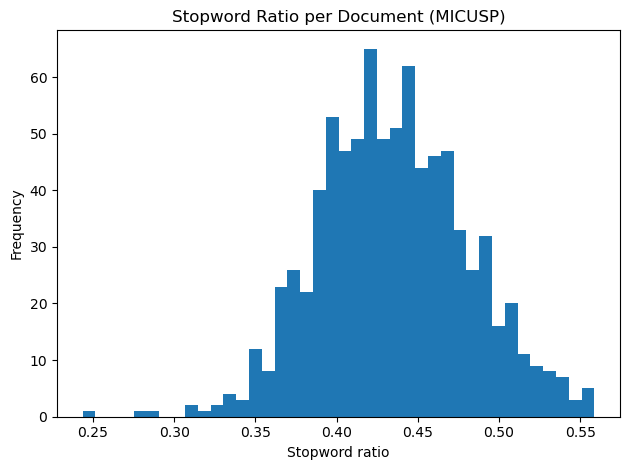

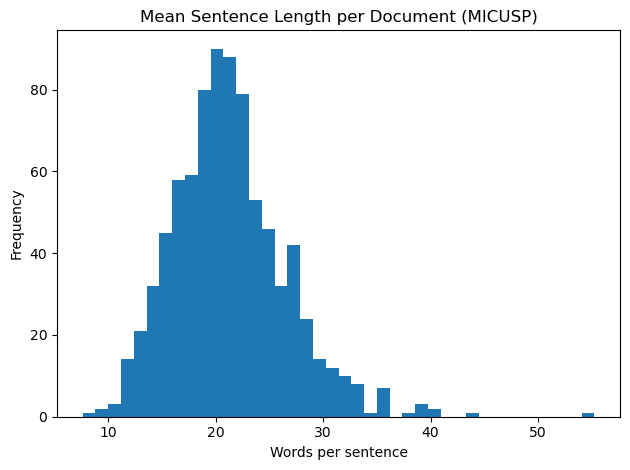

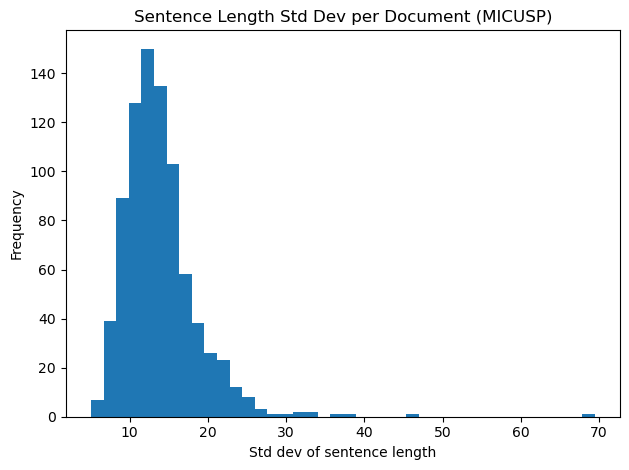

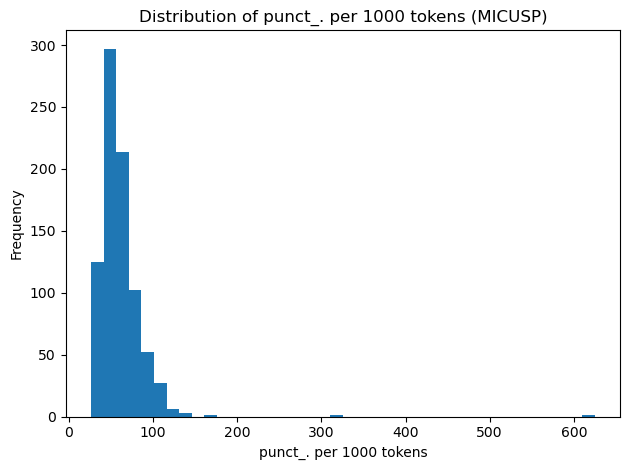

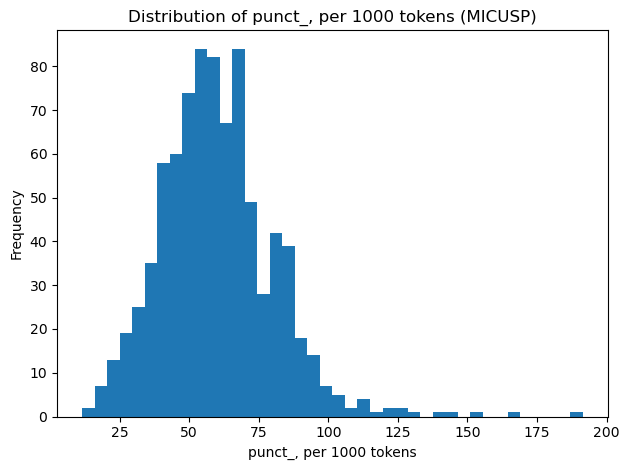

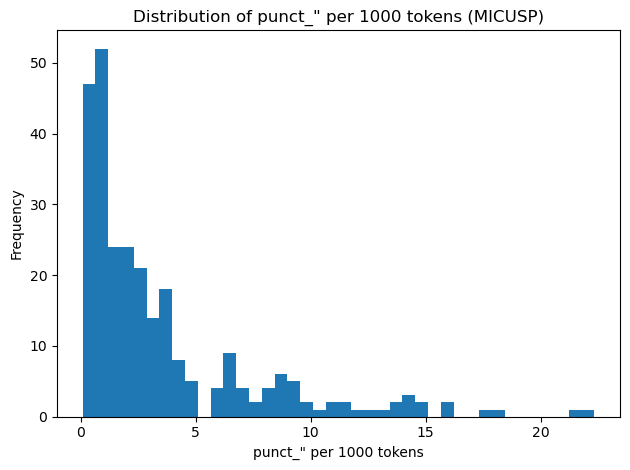

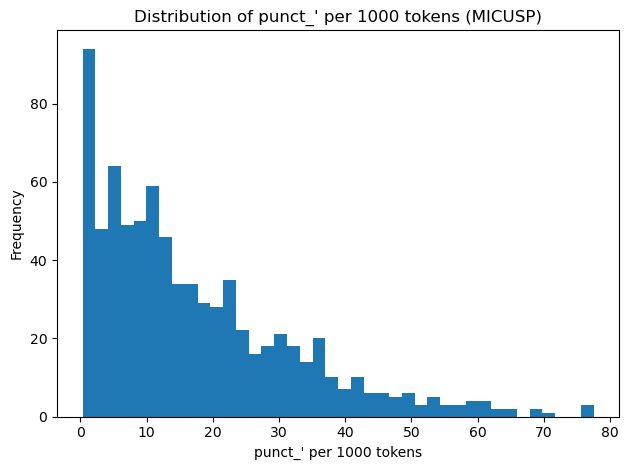

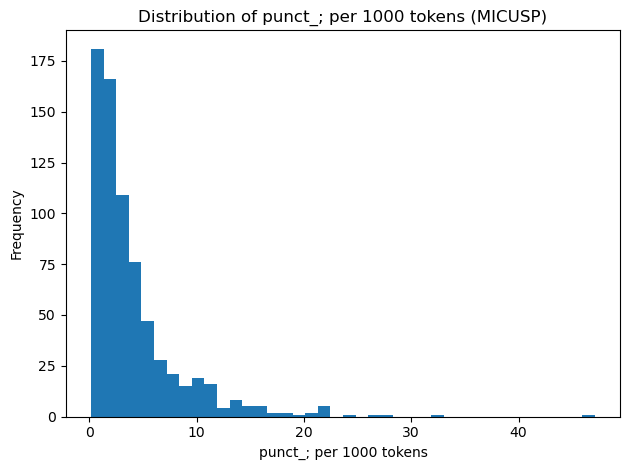

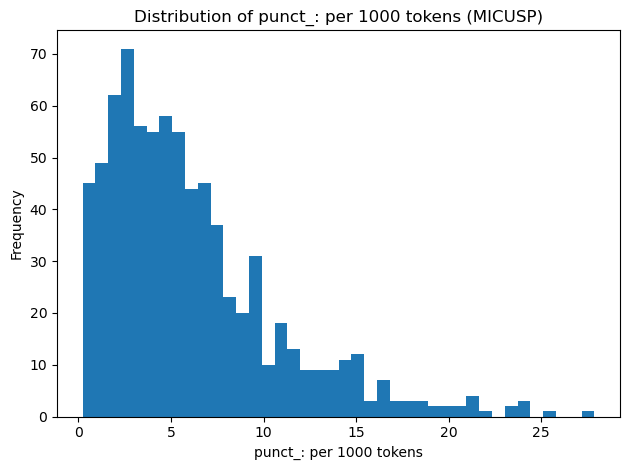

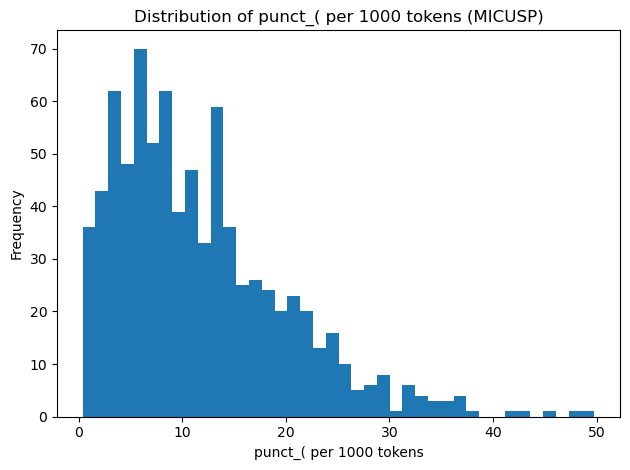

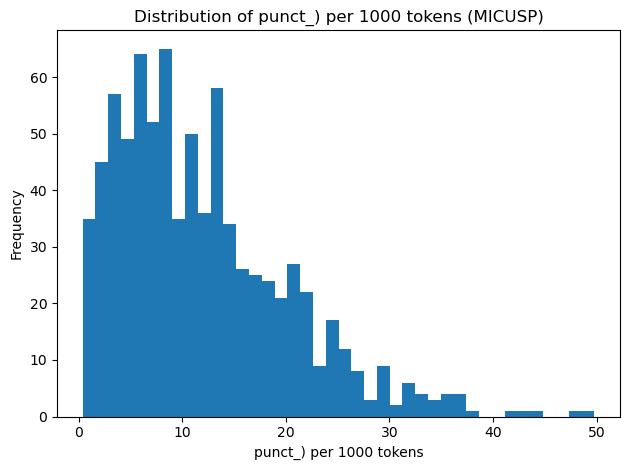

In [6]:
"""Section 3

Stylometry
"""
def doc_stylometry(text: str):
    """Get some stylometric metrics to see how essays compare to newswire, and see if there are any unique characteristics of student essays"""
    tokens = simple_word_tokenize(text)
    n_tokens = len(tokens)
    sw_count = sum(1 for t in tokens if t in STOPWORDS)
    sw_ratio = sw_count / n_tokens if n_tokens else 0.0

    sents = simple_sent_tokenize(text)
    sent_lens = [len(simple_word_tokenize(s)) for s in sents] or [0]
    sent_mean = float(np.mean(sent_lens))
    sent_std = float(np.std(sent_lens))

    punct_chars = ",.;:!?—-()[]\"'"
    punct_counts = Counter(ch for ch in text if ch in punct_chars)
    per_1000 = {f"punct_{k}": (v / n_tokens * 1000.0 if n_tokens else 0.0) for k, v in punct_counts.items()}

    return {"stopword_ratio": sw_ratio, "sent_len_mean": sent_mean, "sent_len_std": sent_std, **per_1000}

stylomat = df["text"].apply(doc_stylometry).apply(pd.Series)
df_stylo = pd.concat([df[["department","path","n_words","n_sents","n_paras","avg_words_per_para"]], stylomat], axis=1)
display(df_stylo.head())

plt.figure()
plt.hist(df_stylo["stopword_ratio"].dropna(), bins=40)
plt.title("Stopword Ratio per Document (MICUSP)")
plt.xlabel("Stopword ratio"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(SAVE_DIR / "section3_stopword_ratio_hist.png", dpi=200)
plt.show()

plt.figure()
plt.hist(df_stylo["sent_len_mean"].dropna(), bins=40)
plt.title("Mean Sentence Length per Document (MICUSP)")
plt.xlabel("Words per sentence"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(SAVE_DIR / "section3_sent_len_mean_hist.png", dpi=200)
plt.show()

plt.figure()
plt.hist(df_stylo["sent_len_std"].dropna(), bins=40)
plt.title("Sentence Length Std Dev per Document (MICUSP)")
plt.xlabel("Std dev of sentence length"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(SAVE_DIR / "section3_sent_len_std_hist.png", dpi=200)
plt.show()

punct_cols = ["punct_.", "punct_,", "punct_\"", "punct_'", "punct_;", "punct_:", "punct_(", "punct_)"]
for col in punct_cols:
    if col in df_stylo.columns:
        plt.figure()
        plt.hist(df_stylo[col].dropna(), bins=40)
        plt.title(f"Distribution of {col} per 1000 tokens (MICUSP)")
        plt.xlabel(f"{col} per 1000 tokens"); plt.ylabel("Frequency")
        plt.tight_layout()
        plt.savefig(SAVE_DIR / f"section3_{col}_hist.png", dpi=200)
        plt.show()


## Section 3: Stylometric Features

**Stopword ratio.** Distribution is entered around **0.40–0.48**, aligning with typical English prose (40–50% - https://www.socratica.com/pages/stop-words#:~:text=overall%20text%20structure:-,English,Russian). This suggests broadly consistent function-word usage across essays.

**Sentence length.**
- **Mean words/sentence** peaks around **19–22**, with a long but thin right tail >30.
- **Std. dev. of sentence length** clusters around **12–15**, indicating moderate within-essay variability (“burstiness”). A few extreme outliers likely come from segmentation noise (e.g., abbreviations like *U.S.*, citation initials).

**Punctuation per 1,000 tokens.**
- **Commas (,)**: Bell-shaped distribution centered roughly **60–80/1k**, consistent with clause-heavy academic style.
- **Periods (.)**: Main mass around **50–100/1k**, but a heavy right tail with extreme outliers. These are probably due to formatting artifacts (table of contents, bibliography, etc).
- **Semicolons (;)**: **Rare**—mostly **0–5/1k** with a sparse right tail; useful as a signal if LLMs overuse “formal” punctuation.
- **Apostrophes (')**: Skewed low but broad (≈ **5–30/1k**). In academic writing these are mostly **possessives**, not contractions.
- **Quotation marks (")**: Generally **low** (≤ **5–10/1k**), reflecting limited direct quotation in many essays.
- **Parentheses (() and ) )**: Distributions track each other and are notably present (**~5–15/1k** typical), matching **citation patterns** (e.g., APA author–year). These metrics correlate with the separate citation-density features.

**Takeaways / caveats.**
- Stylometric profiles (stopwords, sentence length, comma usage) differ from newswire, with **shorter mean sentence length** and **greater variance**.  Additionally, there are **far fewer quotation marks**.
- The **period outliers** and some punctuation spikes are likely due to **front/back matter** (Table of Contents, References) and possibly ASCII artifacts; keep in mind for downstream comparisons.



,department,path,cite_yearparen_per_1000,cite_authoryear_per_1000,passive_per_1000,cue_introduction,cue_method,cue_methods,cue_methodology,cue_results,cue_discussion,cue_conclusion,cue_conclusions,cue_references,cue_acknowledgments,cue_acknowledgements
0,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.01....,0.000000,0.000000,8.162556,3.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0
1,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,8.961518,2.108593,7.380074,2.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0
2,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,4.889976,1.222494,3.667482,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,3.225806,3.225806,8.064516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,4.411765,1.470588,2.941176,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


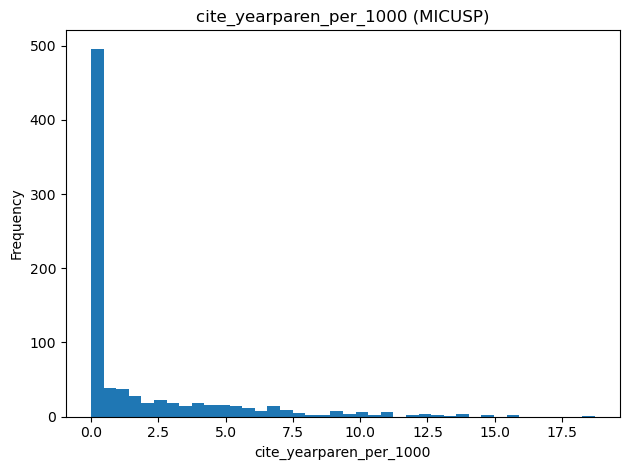

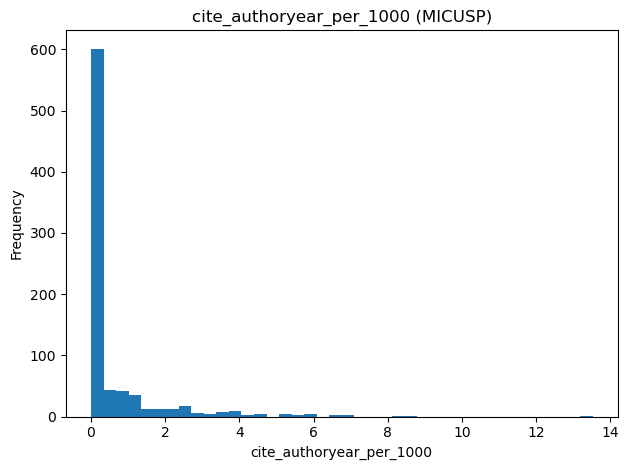

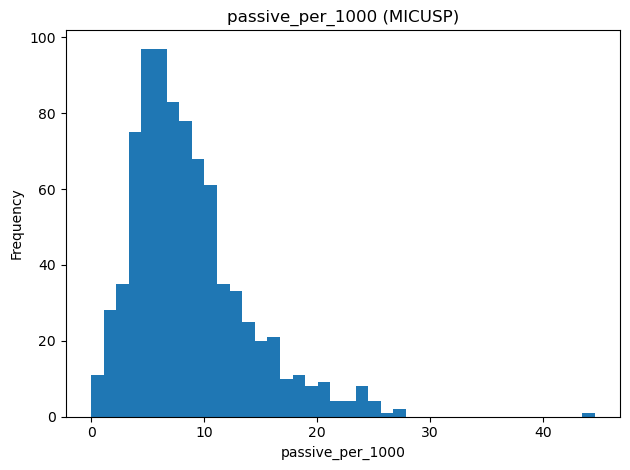

In [7]:
"""Section 3.1

Essay-specific characteristics
"""

# Regex for finding citations
YEAR_PAREN_RE = re.compile(r"\((19|20)\d{2}[a-z]?\)")
AUTHOR_YEAR_RE = re.compile(r"[A-Z][a-z]+(?:\s&\s[A-Z][a-z]+)?\s\((19|20)\d{2}[a-z]?\)")
# Regex for passive voice indicators (not perfect; will lead to some false positives and false negatives)
PASSIVE_RE = re.compile(r"\b(am|is|are|was|were|be|been|being)\s+[a-z]+ed\b", re.IGNORECASE)

# Some of the essays have section headers
SECTION_CUES = ["introduction", "method", "methods", "methodology", "results", "discussion",
                "conclusion", "conclusions", "references", "acknowledgments", "acknowledgements"]

def essay_specific_metrics(text: str) -> dict:
    """Get some essay-specific metrics to gain insights on how we want to preprocess the data"""
    tokens = simple_word_tokenize(text)
    n_tokens = len(tokens)

    year_paren = len(YEAR_PAREN_RE.findall(text))
    author_year = len(AUTHOR_YEAR_RE.findall(text))
    cit_per_1000 = {
        "cite_yearparen_per_1000": (year_paren / max(1, n_tokens)) * 1000.0,
        "cite_authoryear_per_1000": (author_year / max(1, n_tokens)) * 1000.0,
    }

    passive_hits = len(PASSIVE_RE.findall(text))
    passive_per_1000 = (passive_hits / max(1, n_tokens)) * 1000.0

    tok_set = Counter(tokens)
    section_counts = {f"cue_{c}": tok_set.get(c, 0) for c in SECTION_CUES}

    return {
        **cit_per_1000,
        "passive_per_1000": passive_per_1000,
        **section_counts
    }

essay_feats = df["text"].apply(essay_specific_metrics).apply(pd.Series)
df_essay = pd.concat([df[["department","path"]], essay_feats], axis=1)
display(df_essay.head())

for col in ["cite_yearparen_per_1000", "cite_authoryear_per_1000", "passive_per_1000"]:
    plt.figure()
    plt.hist(df_essay[col].dropna(), bins=40)
    plt.title(f"{col} (MICUSP)")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(SAVE_DIR / f"section_.01_{col}_hist.png", dpi=200)
    plt.show()


## Section 3.1: Essay-specific signals (citations & passive voice)

**Citation density (per 1,000 tokens).**
- **Author–year (`cite_authoryear_per_1000`)**: Heavy spike at **0** with a long, thin right tail (up to ~**14/1k**). Many essays use **no in-text author–year citations**, or use alternative styles (footnotes/numerals), while a minority (lit-review / methods-heavy) show higher rates.
- **Year-in-parentheses (`cite_yearparen_per_1000`)**: Similar shape, but a **broader tail** (up to ~**18/1k**). This capture is looser and may include **dates that aren’t citations** (e.g., years in titles or examples), so treat as an **upper bound**.

**Passive voice heuristic (`passive_per_1000`).**
- Unimodal distribution centered roughly around **7–12 per 1,000 tokens**, with a right tail past **25** (rare outliers near **40+**).
- True positives like: was measured, is considered, are required, being tested.
- False positives like: is interested, was tired, are related.
- False negatives like: was not fully validated, were quickly randomized, is known.

**Interpretation & caveats.**
- The large mass at **zero citations** plus long tails suggests differences between departments/topics (some courses emphasize citation practice more than others).
- Counts can be inflated by **front/back matter** (TOC, References) and ASCII artifacts; we will probably want to remove those in preprocessing.

**Notes for pre-processing.**
- Either limit citation counts to the **main body** (truncate after “References/Bibliography”), or get rid of them altogether.
- Expand citation patterns to include **`and`** and **`et al.`**, and exclude **month names** to reduce false positives.

,department,path,rep_unigram_frac,rep_bigram_frac
0,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.01....,0.851685,0.351225
1,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,0.849499,0.338518
2,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,0.735941,0.193390
3,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,0.691935,0.206785
4,BIO,data/micusp/MICUSP_byDept-ASCII/BIO/BIO.G0.02....,0.707353,0.201767


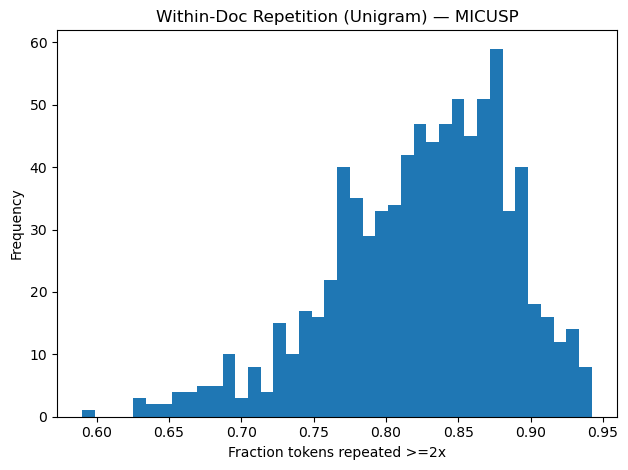

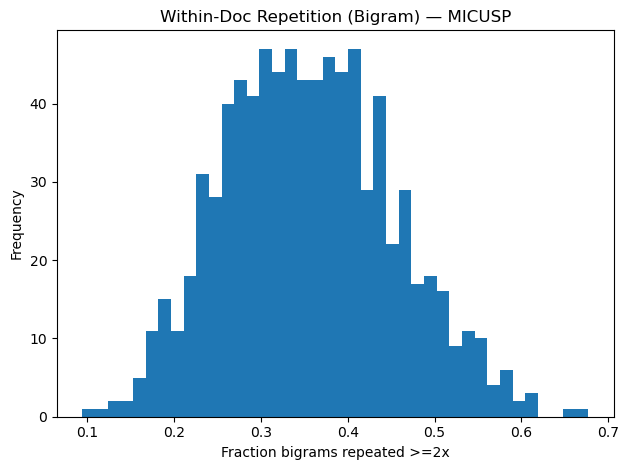

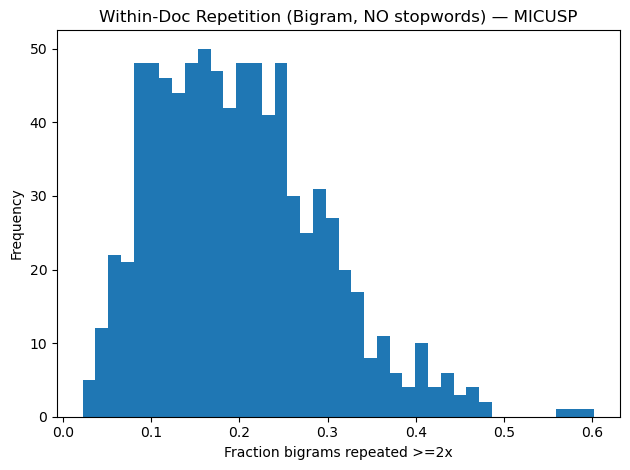

,word,vmr,mean
166,violence,123.165032,1.190591
116,energy,73.813428,1.452352
199,sexual,58.845149,1.097708
15,women,57.448653,3.237636
29,education,56.298943,2.528347
3,amp,52.614056,4.740651
62,community,52.078523,1.950543
146,identity,51.795597,1.276236
149,english,49.566452,1.270205
191,idea,49.143921,1.118215


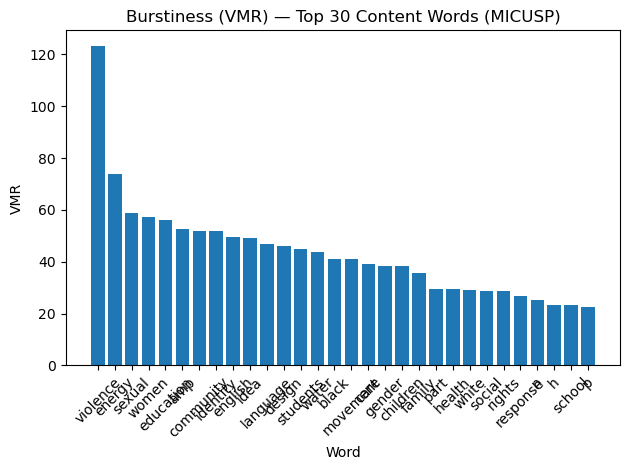

In [8]:
"""Section 4

Burstiness & Repetition
"""

def repetition_metrics(text: str):
    toks = simple_word_tokenize(text)
    n = len(toks)
    if n == 0:
        return {"rep_unigram_frac": 0.0, "rep_bigram_frac": 0.0}
    uni = Counter(toks)
    rep_uni = sum(c for c in uni.values() if c >= 2)
    rep_uni_frac = rep_uni / n
    bigrams = Counter(zip(toks[:-1], toks[1:], strict=False))
    rep_bi = sum(c for c in bigrams.values() if c >= 2)
    rep_bi_frac = rep_bi / max(1, n - 1)
    return {"rep_unigram_frac": rep_uni_frac, "rep_bigram_frac": rep_bi_frac}

rep_df = df["text"].apply(repetition_metrics).apply(pd.Series)
df_rep = pd.concat([df[["department","path"]], rep_df], axis=1)
display(df_rep.head())

plt.figure()
plt.hist(df_rep["rep_unigram_frac"].dropna(), bins=40)
plt.title("Within-Doc Repetition (Unigram) — MICUSP")
plt.xlabel("Fraction tokens repeated >=2x"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(SAVE_DIR / "section4_repetition_unigram_hist.png", dpi=200)
plt.show()

plt.figure()
plt.hist(df_rep["rep_bigram_frac"].dropna(), bins=40)
plt.title("Within-Doc Repetition (Bigram) — MICUSP")
plt.xlabel("Fraction bigrams repeated >=2x"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(SAVE_DIR / "section4_repetition_bigram_hist.png", dpi=200)
plt.show()

def bigram_repetition_without_stopwords(text: str, stopwords=None):
    if stopwords is None:
        stopwords = STOPWORDS
    toks = [t for t in simple_word_tokenize(text) if t not in stopwords]
    if len(toks) < 2:
        return 0.0
    bigrams = Counter(zip(toks[:-1], toks[1:], strict=False))
    rep = sum(c for c in bigrams.values() if c >= 2)
    return rep / (len(toks) - 1)

rep_bi_no_sw = df["text"].apply(bigram_repetition_without_stopwords)
df_rep = df_rep.copy()
df_rep["rep_bigram_frac_no_sw"] = rep_bi_no_sw

plt.figure()
plt.hist(df_rep["rep_bigram_frac_no_sw"].dropna(), bins=40)
plt.title("Within-Doc Repetition (Bigram, NO stopwords) — MICUSP")
plt.xlabel("Fraction bigrams repeated >=2x"); plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(SAVE_DIR / "section4_repetition_bigram_without_stopwords_hist.png", dpi=200)
plt.show()

# Burstiness (NO stopwords)
K = 200
docs_tokens = [[t for t in simple_word_tokenize(txt) if t not in STOPWORDS] for txt in df["text"]]
global_counts = Counter(t for doc in docs_tokens for t in doc)
top_words = [w for w, _ in global_counts.most_common(K)]

counts_rows = []
for doc in docs_tokens:
    c = Counter(doc)
    counts_rows.append([c.get(w, 0) for w in top_words])
mat = np.asarray(counts_rows, dtype=float)
means = mat.mean(axis=0)
vars_  = mat.var(axis=0)
vmr = np.divide(vars_, means, out=np.zeros_like(vars_), where=means > 0)

burst_df_no_sw = pd.DataFrame({"word": top_words, "vmr": vmr, "mean": means})
burst_df_no_sw_sorted = burst_df_no_sw.sort_values("vmr", ascending=False).head(30)
display(burst_df_no_sw_sorted)

plt.figure()
plt.bar(burst_df_no_sw_sorted["word"], burst_df_no_sw_sorted["vmr"])
plt.title("Burstiness (VMR) — Top 30 Content Words (MICUSP)")
plt.xlabel("Word"); plt.ylabel("VMR")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(SAVE_DIR / "section4_burstiness_top30_no_stopwords_vmr.png", dpi=200)
plt.show()


## Section 4: Repetition & Burstiness — MICUSP vs. Newswire

**Within-doc repetition**
- **Unigrams:** Very high reuse — most essays have **~0.80–0.90** of tokens occurring ≥2×.
- **Bigrams (WITH stopwords):** Centered around **~0.38–0.42**, i.e., ~40% of bigrams repeat ≥2×.
- **Bigrams (NO stopwords):** Shifts lower to roughly **~0.12–0.25**, reflecting reuse of topical phrases rather than function-word frames.

**Burstiness across documents (VMR on top content words)**
- The variance-to-mean ratio (VMR) compares how much a count varies to its average to show whether it’s spread evenly or clumped. Near-0 indicates **evenly-distributed** words, while very large numbers indicate **bursty behavior**.
- Extremely **bursty topics**: e.g., *violence, energy, sexual, women, education* show **very high VMR** (top term >100), meaning they appear densely in a subset of essays and rarely elsewhere.
- Presence of artifacts (e.g., **“amp”**) signals residual HTML entities — a cleanup pass will reduce spurious burstiness.

**Comparison to newswire (Reuters baseline)**
- Reuters showed **much lower bigram repetition** (≈**0.10–0.20** with stopwords; **≈0.05–0.10** without) and **moderate VMR** (single-digit to low teens for frequent terms).  
- MICUSP essays are **far more repetitive** (especially with stopwords) and **more bursty by topic**. Two drivers:
  1) **Longer documents** → more opportunities to reuse the same terms and phrasings.
  2) **Assignment/domain concentration** → topic words cluster within departments/essay prompts.


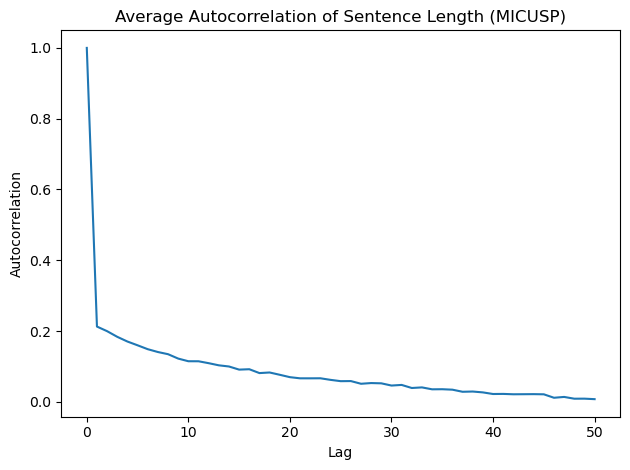

Docs used for ACF: 829


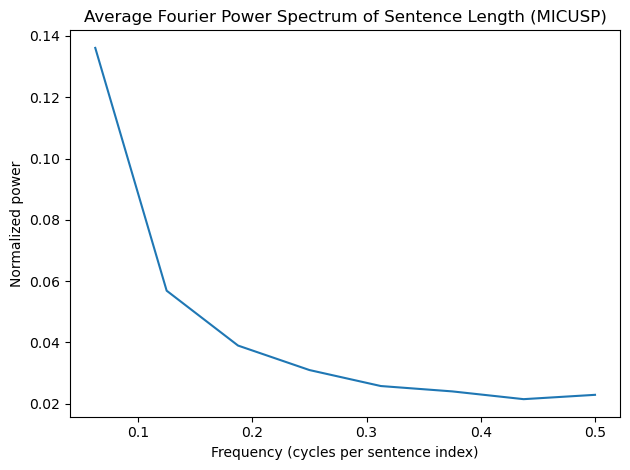

Docs used for FFT: 829


In [9]:
"""Section 5

Temporal / Sequential Structure (Signal Proxies)
"""

def sent_lengths(text):
    sents = simple_sent_tokenize(text)
    return [len(simple_word_tokenize(s)) for s in sents if s.strip()]

max_lag = 50
acfs = []
for txt in df["text"]:
    sl = sent_lengths(txt)
    if len(sl) < 3:
        continue
    x = np.asarray(sl, dtype=float)
    x = x - x.mean()
    s = x.std()
    if s == 0:
        continue
    x /= s
    c = np.correlate(x, x, mode="full")
    mid = len(c) // 2
    max_avail = len(x) - 1
    L = min(max_lag, max_avail)
    acf = c[mid:mid+L+1] / c[mid]
    if L < max_lag:
        pad = np.full((max_lag - L,), np.nan)
        acf = np.concatenate([acf, pad])
    acfs.append(acf)

if not acfs:
    raise ValueError("No documents had enough sentences for autocorrelation.")

A = np.vstack(acfs)
avg_acf = np.nanmean(A, axis=0)

plt.figure()
plt.plot(np.arange(len(avg_acf)), avg_acf)
plt.title("Average Autocorrelation of Sentence Length (MICUSP)")
plt.xlabel("Lag"); plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.savefig(SAVE_DIR / "section5_sentlen_autocorrelation.png", dpi=200)
plt.show()
print(f"Docs used for ACF: {A.shape[0]}")

# Fourier spectrum
all_specs = []
for txt in df["text"]:
    sl = sent_lengths(txt)
    if len(sl) < 8:
        continue
    x = np.array(sl, dtype=float)
    x = x - x.mean()
    spec = np.abs(np.fft.rfft(x))**2
    ssum = spec.sum()
    if ssum == 0:
        continue
    spec = spec / ssum
    all_specs.append(spec)

if not all_specs:
    raise ValueError("No documents had enough sentences for Fourier analysis.")

Nf = min(len(s) for s in all_specs)
spec_stack = np.vstack([s[:Nf] for s in all_specs])
avg_spec = spec_stack.mean(axis=0)

N_time = int(2 * (Nf - 1))
freqs = np.fft.rfftfreq(N_time, d=1.0)

plt.figure()
plt.plot(freqs[1:], avg_spec[1:])
plt.title("Average Fourier Power Spectrum of Sentence Length (MICUSP)")
plt.xlabel("Frequency (cycles per sentence index)"); plt.ylabel("Normalized power")
plt.tight_layout()
plt.savefig(SAVE_DIR / "section5_sentlen_fourier_spectrum.png", dpi=200)
plt.show()
print(f"Docs used for FFT: {spec_stack.shape[0]}")


## Section 5: Temporal / Sequential Structure (Sentence-length dynamics)

**Autocorrelation (ACF).**  
The average ACF drops from 1.0 at lag 0 to ~0.2 at lag 1 and then decays smoothly toward ~0 by lags ~30–40. This indicates there is some correlation of consecutive sentence lengths (a long sentence **more likely to be followed** by another longish one) but **much weaker correlation** or periodic alternation for longer-range dependencies.

**Fourier spectrum.**  
Power is concentrated at the **lowest frequencies** with no sharp peaks, then falls off steadily. That pattern is consistent with **slow drift** in sentence length across sections of an essay rather than any fixed rhythm (e.g., alternating short/long).

**Implications / caveats.**  
- Human essays appear to be **locally smooth but non-periodic** in sentence length.  
- Minor high-frequency noise may stem from simple sentence segmentation (abbreviations, citations).  

Saved correlations CSV: eda_outputs/micusp_student_essays/section6_feature_correlations.csv


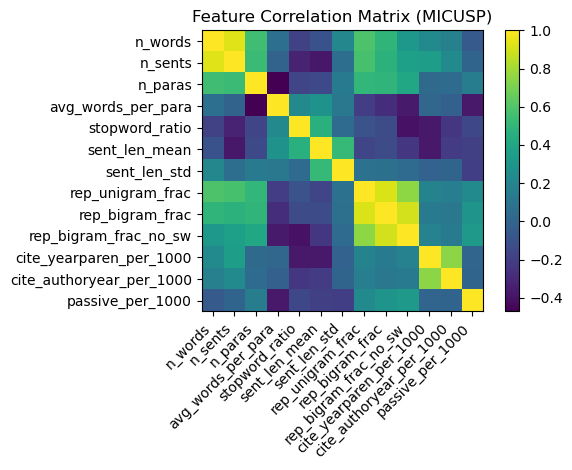

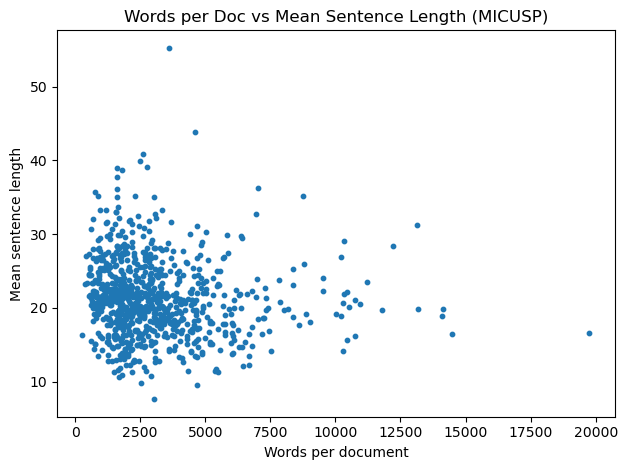

In [10]:
"""Section 6

Correlations & Quick Dashboard
"""

features = pd.concat(
    [
        df[["n_words","n_sents","n_paras","avg_words_per_para"]],
        df_stylo[["stopword_ratio","sent_len_mean","sent_len_std"]],
        df_rep[["rep_unigram_frac","rep_bigram_frac","rep_bigram_frac_no_sw"]],
        df_essay[["cite_yearparen_per_1000","cite_authoryear_per_1000","passive_per_1000"]],
    ],
    axis=1
)

corr = features.corr(numeric_only=True)
corr_csv = SAVE_DIR / "section6_feature_correlations.csv"
corr.to_csv(corr_csv)
print(f"Saved correlations CSV: {corr_csv.as_posix()}")

plt.figure()
plt.imshow(corr)
plt.title("Feature Correlation Matrix (MICUSP)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.tight_layout()
plt.savefig(SAVE_DIR / "section6_feature_correlation_matrix.png", dpi=200)
plt.show()

plt.figure()
plt.scatter(features["n_words"], features["sent_len_mean"], s=10)
plt.title("Words per Doc vs Mean Sentence Length (MICUSP)")
plt.xlabel("Words per document"); plt.ylabel("Mean sentence length")
plt.tight_layout()
plt.savefig(SAVE_DIR / "section6_words_vs_sentlen_scatter.png", dpi=200)
plt.show()


## Section 6: Correlations & Cross-feature Relationships

**Length block.**  
- `n_words` and `n_sents` are **strongly correlated** (longer essays == more sentences).  
- `avg_words_per_para` is **inverseley correlated** to `n_paras` (more paragraphs == shorter paragraphs on average).  
- The scatter (`words` vs `mean sentence length`) shows **little to no correlation**: longer essays don’t necessarily have longer or shorter sentences.

**Sentence & repetition block.**  
- `sent_len_mean` and `sent_len_std` **somewhat correlated** to each other, but nothing else.  
- Repetition measures **track one another**: 
- Repetition features show **moderate correlation** to document/sentence length (longer essays reuse more words/phrases).

**Citation & passive features.**  
- The two citation densities (`cite_yearparen_per_1000`, `cite_authoryear_per_1000`) **co-vary** but are largely **orthogonal** to length and sentence metrics—more about assignment/discipline than size.  
- `passive_per_1000` is mostly **independent** of length; any associations are **small**.

### Brief contrast with newswire
- **Shared patterns:** `n_words`–`n_sents` high correlation; stopword ratio and mean sentence length show **weak ties** to other features; repetition metrics are **mutually correlated**.  
- **Differences:** MICUSP exhibits **stronger repetition–length coupling**. Newswire articles are length-standardized, so repetition and sentence-length variability tend to be **tighter** than in these longer, heterogeneous student essays.


In [11]:
"""Bonus Section 

Department-level metrics
"""

# Department-level breakouts
dept_means = (
    pd.concat([df[["department"]], features], axis=1)
      .groupby("department", as_index=False)
      .mean(numeric_only=True)
      .sort_values("n_words", ascending=False)
)

display(dept_means.head(10))
dept_means_path = SAVE_DIR / "section_bonus_department_means.csv"
dept_means.to_csv(dept_means_path, index=False)
print(f"Saved department means: {dept_means_path.as_posix()}")


,department,n_words,n_sents,n_paras,avg_words_per_para,stopword_ratio,sent_len_mean,sent_len_std,rep_unigram_frac,rep_bigram_frac,rep_bigram_frac_no_sw,cite_yearparen_per_1000,cite_authoryear_per_1000,passive_per_1000
5,HIS_CLS,4435.525000,188.825000,35.350000,143.270510,0.438685,25.589849,17.799676,0.796059,0.315154,0.152989,0.748358,0.432956,5.266031
7,LIN,3751.975610,181.439024,77.439024,74.990450,0.450789,21.831012,14.853697,0.854959,0.392350,0.214704,1.624311,0.756710,9.932836
10,NUR,3731.666667,218.761905,44.523810,101.605316,0.413892,18.047151,12.366794,0.844423,0.371077,0.217287,4.547545,0.989112,9.453209
8,MEC,3728.718750,198.750000,92.031250,47.100450,0.410604,19.407203,13.590522,0.877865,0.461823,0.302625,0.711363,0.047993,14.043643
13,POL,3352.016129,157.225806,27.161290,133.328618,0.424858,22.609274,15.115415,0.817668,0.341400,0.185536,0.814109,0.228574,6.702688
3,EDU,3222.586957,160.108696,32.630435,118.822994,0.449699,22.241037,15.094188,0.823414,0.345509,0.183592,2.161134,0.679096,5.469888
1,CEE,3093.548387,186.064516,60.322581,62.372281,0.404582,18.387527,11.935275,0.854743,0.411112,0.270808,0.809673,0.456650,16.693695
14,PSY,3077.230769,173.682692,28.384615,117.423150,0.427591,18.921586,12.667722,0.826376,0.350129,0.201196,4.801204,1.349812,8.402991
2,ECO,3057.640000,143.440000,55.160000,86.118239,0.423357,21.985810,12.670553,0.833574,0.384881,0.238878,1.497880,1.095481,7.148480
15,SOC,2950.708333,141.500000,29.763889,114.217696,0.447911,22.948350,14.681126,0.804743,0.318669,0.155972,1.284123,0.625327,7.532350


Saved department means: eda_outputs/micusp_student_essays/section_bonus_department_means.csv



## Bonus Section : Department-Level Metrics

- History essays are **significantly wordier** than other sections.
- Bigram frequencies indicate **jargon** in technical fields (MEC, CEE have high bigram counts).
- Technical subjects also have a much higher incidence of **probable passive voice**.